In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
## import trajectory data
df = pd.read_csv('trajectory.csv')
df.head()
# df to numpy array
data = df.to_numpy()
data.shape
trajectory = np.delete(data, 2, 1)
trajectory = np.delete(trajectory, -1, 1)
trajectory.shape

/var/folders/cf/x6zpxdwn2dg40q0c0r418f7c0000gp/T/ipykernel_4211/2851380134.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


(9999, 4)

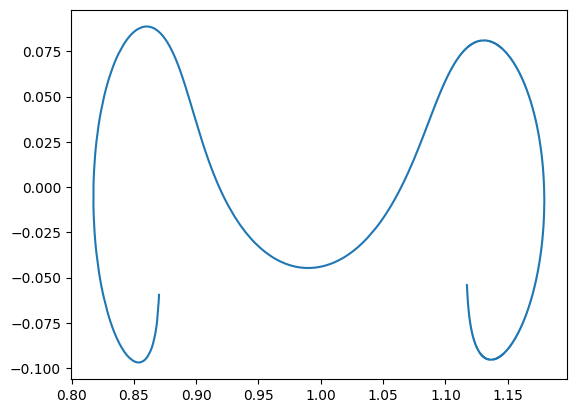

In [3]:
plt.plot(trajectory[:,0], trajectory[:,1])

In [4]:
# three body problem env
import gym
from gym import spaces
import numpy as np

class three_body_env(gym.Env):
    def __init__(self, trajectory):
        self.trajectory = trajectory
        self.state = np.zeros(4)
        self.dt = 0.01
        self.mu = 0.012277471
        self.action_space = spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(4,), dtype=np.float32)
        self.position = trajectory[0]
        self.steps = 0
        self.max_steps = 1000
        self.reward_range = (-float('inf'), float('inf'))
        self.reset()

    def step(self, action):
        x = self.position[0]
        y = self.position[1]
        xdot = self.position[2]
        ydot = self.position[3]

        a_x = action[0]
        a_y = action[1]

        r1 = np.sqrt((x+self.mu)**2 + y**2)
        r2 = np.sqrt((x-1+self.mu)**2 + y**2)

        xddot = 2*ydot + x -(1-self.mu)*((x+self.mu)/(r1**3)) - self.mu*(x-1+self.mu)/(r2**3) + a_x
        yddot = -2*xdot + y - (1-self.mu)*(y/(r1**3)) - self.mu*(y)/(r2**3) + a_y

        x = x + xdot*self.dt
        y = y + ydot*self.dt
        
        xdot = xdot + xddot*self.dt
        ydot = ydot + yddot*self.dt

        self.position = np.array([x, y, xdot, ydot])

        self.steps += 1

        self.position2state()

        reward = 1 - np.linalg.norm(self.position - self.trajectory[self.steps], axis=0)
        done = self.steps >= self.max_steps
        if abs(self.position - self.trajectory[-1]).sum() < 0.005:
            done = True
            reward = 1000
        if self.steps > 1000:
            done = True
            reward = -1000
        if np.linalg.norm(self.state) > 2:
            done = True
            reward = -1000

        return self.state, reward, done, self.position

    def position2state(self):
        # find nearest point from position to trajectory
        distance = np.linalg.norm(self.trajectory - self.position, axis=1)
        nearest_idx = np.argmin(distance)
        # estate = position - nearest(index)
        self.state = self.position - self.trajectory[nearest_idx]
    
    def reset(self):
        self.position = self.trajectory[0]   
        self.steps = 0
        self.position2state()
        return self.state
    
    def render(self):
        pass

    def close(self):
        pass

    



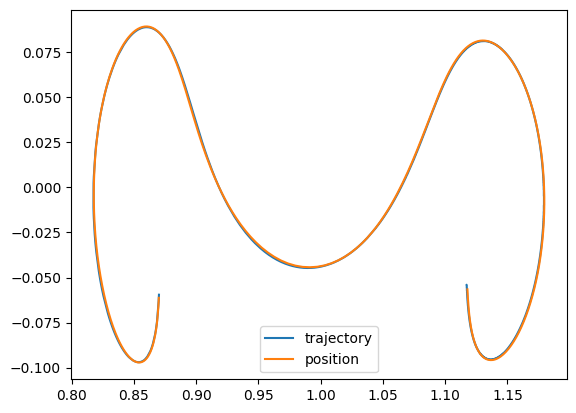

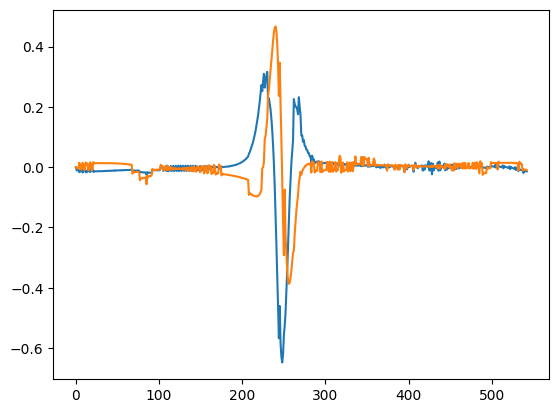

In [5]:
env = three_body_env(trajectory)
env.reset()
# save position
position_array = []
action_array = []
state_array = []
# using PD Guidance
for i in range(600):
    action = -120 * env.state[2:] - 70 * env.state[:2]
    # print(action)
    action_array.append(action)
    state, reward, done, position = env.step(action)
    state_array.append(state)
    position_array.append(position)
    if done:
        break
plt.plot(trajectory[:,0], trajectory[:,1])
plt.plot(np.array(position_array)[:,0], np.array(position_array)[:,1])
# legned
plt.legend(['trajectory', 'position'])
plt.show()
plt.plot(action_array)


In [6]:
import tensorflow as tf
import tensorlayer as tl
from tensorflow.keras import layers

def get_actor(num_states, upper_bound):

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(2, activation="tanh")(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

# train model
x = state_array
y = action_array

# to tensor
x = tf.convert_to_tensor(x, dtype=tf.float32)
y = tf.convert_to_tensor(y, dtype=tf.float32)
model = get_actor(4, 1)
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x, y, epochs=100, verbose=1)

# Save the model
model.save('model.h5')

# load model
model = tf.keras.models.load_model('model.h5')

2024-02-06 18:36:53.685519: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
17/17 [==============================] - 1s 3ms/step - loss: 0.0086
Epoch 2/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 4/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 5/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 6/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 7/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 8/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 9/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 10/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 11/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 12/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 13/100
17/17 [=================

/Users/Ali/Documents/BAI/Master/master-thesis/.env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


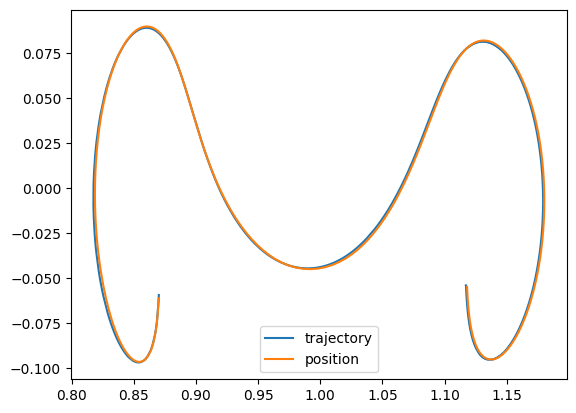

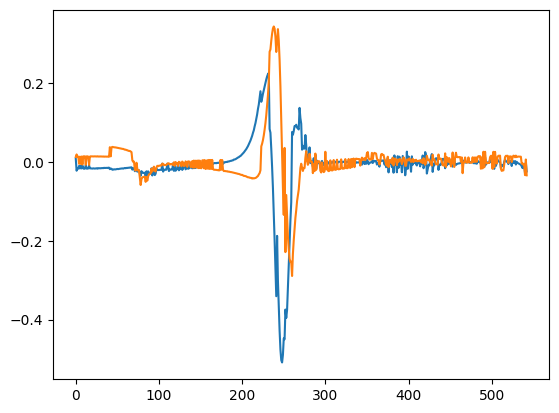

In [9]:
env = three_body_env(trajectory)
state = env.reset()
# save position
position_array = []
action_array = []
state_array = []
# using PD Guidance
for i in range(600):
    action = tf.squeeze(model(state.reshape(1,4)))
    # print(action)
    action_array.append(action)
    state, reward, done, position = env.step(action)
    state_array.append(state)
    position_array.append(position)
    if done:
        break
plt.plot(trajectory[:,0], trajectory[:,1])
plt.plot(np.array(position_array)[:,0], np.array(position_array)[:,1])
# legend
plt.legend(['trajectory', 'position'])
plt.show()
plt.plot(action_array)